In [1]:
import sys
import os

# # Simple approach: add the parent directory to Python path
# project_root = os.path.dirname(os.getcwd())
# sys.path.insert(0, project_root)
# print(f"Added {project_root} to Python path")
# print(f"Current working directory: {os.getcwd()}")

import pickle
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from functions_parameters.universal_parameters import a, b
from itertools import product

In [2]:
final_result = np.load('u_v1_filling_0p5_t_4_em4_random_basis_mesh_60_gpu_scaling.npz')


final_ground_state_e_diff_density = final_result['gse']
final_density = final_result['d']
final_bond = final_result['bond']
final_e_difference = final_result['e_diff']
final_c_difference = final_result['c_diff']
final_e_fermi = final_result['e_fermi']
final_iteration = final_result['iters']
any_bi_fail = final_result['any_bi_fail']

u_arr = final_result['u']
v1_arr = u_arr
u_mesh, v1_mesh = np.meshgrid(u_arr, v1_arr, indexing = 'ij')

In [3]:
np.max(final_c_difference)

np.float64(9.999958971995682e-08)

In [4]:
np.max(final_e_difference)

np.float64(9.996755381824762e-09)

### Phase Analysis

In [5]:
from functions_parameters.tools import rot_symm_m_check_d
from functions_parameters.universal_parameters import pauli_matrices

c_6 = np.array([[0,0,1],
               [1,0,0],
               [0,1,0]])
c_3 = c_6@c_6
c_2 = c_6 @ c_3

In [6]:
nematic_phase = ['R symmetric', 'C3 charge nematic', 'C2 charge nematic', 'no R']
Magnetism_phase = [' +', ' FM', ' Ferri', ' AFM']

phase_list_final = list(i+j for i,j in product(nematic_phase, Magnetism_phase))

In [7]:
sorted_ground_state_e_index = np.argsort(final_ground_state_e_diff_density, axis=2)
sorted_ground_state_e= np.take_along_axis(final_ground_state_e_diff_density, sorted_ground_state_e_index, axis=2)
sorted_density = np.take_along_axis(final_density, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis], axis=2)
sorted_e_difference = np.take_along_axis(final_e_difference, sorted_ground_state_e_index, axis=2)
sorted_c_difference = np.take_along_axis(final_c_difference, sorted_ground_state_e_index, axis=2)

In [8]:
threshold = 1E-2

phase_diagram_based_on_d = np.zeros(u_mesh.shape)
for i in range(u_mesh.shape[0]):
    for j in range(u_mesh.shape[1]):
        d_o = sorted_density[i,j,0]
        rs_recording = np.zeros((4))
        m_recording = np.zeros((4))
        c6_diff, c3_diff, c2_diff, magnetism_arr = rot_symm_m_check_d(d_o, c_6, c_3, c_2)
        if c6_diff<threshold:
            rs_recording[0] = 1
        elif c6_diff>threshold and c3_diff<threshold:
            rs_recording[1] = 1
        elif c2_diff<threshold and c6_diff>threshold:
            rs_recording[2] = 1
        # else:
        #     rs_recording[3] = 1
        if np.max(np.abs(magnetism_arr)) > threshold:
            # FM: all components aligned and above threshold
            if np.all(np.sign(np.real(magnetism_arr)) == 1) or np.all(np.sign(np.real(magnetism_arr)) == -1):
                m_recording[1] = 1
            else:
                net_m = np.sum(np.real(magnetism_arr))
                # AFM: mixed signs with near-zero net moment
                if np.abs(net_m) <= threshold:
                    m_recording[3] = 1
                else:
                    # Ferri: mixed signs with non-zero net moment
                    m_recording[2] = 1
        else:
            m_recording[0] = 1
        phase_arr = np.kron(rs_recording,m_recording)
        phase = np.where(phase_arr>0.5)[0][0]
        # it this right???????
        phase_diagram_based_on_d[i,j]=phase

Text(0.5, 1.0, 'filling = 1')

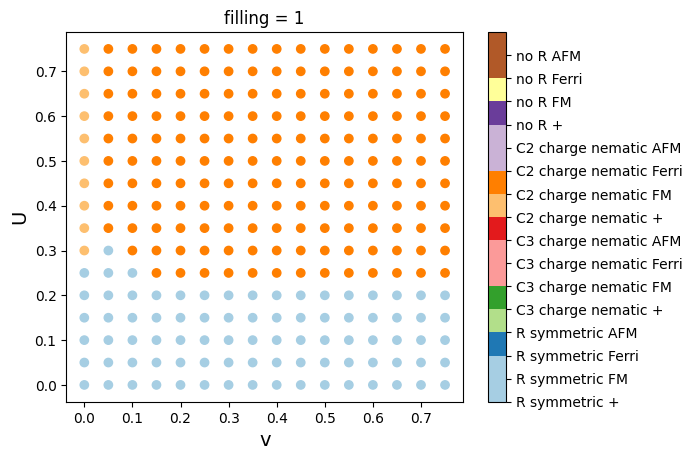

In [9]:
colorbar_ticks_combined = np.arange(len(phase_list_final))
cmap = plt.get_cmap("Paired", len(phase_list_final))
# plt.pcolormesh(e_fermi_mesh, u_mesh, phase_diagram_combined_op.T, cmap="Paired")
plt.scatter(u_mesh, v1_mesh, c=phase_diagram_based_on_d, cmap=cmap,vmin=0, vmax=len(phase_list_final))
# plt.xlabel(r'$E_{f}$', size = '14')
plt.xlabel('v', size = '14')
plt.ylabel('U', size = '14')
# plt.xlim(3.8,6)
colorbar_ticks = np.arange(len(phase_list_final))
cbar = plt.colorbar()
cbar.set_ticks(colorbar_ticks)
cbar.set_ticklabels(phase_list_final)
plt.title('filling = 1')

In [10]:
unique_phase_index = np.unique(phase_diagram_based_on_d)
unique_phase_name = [phase_list_final[i] for i in np.int_(unique_phase_index)]
filtered_phase_diagram = np.zeros(phase_diagram_based_on_d.shape)
for i in range(u_mesh.shape[0]):
    for j in range(u_mesh.shape[1]):
        filtered_phase_diagram[i,j] = np.where(unique_phase_index==phase_diagram_based_on_d[i,j])[0][0]

Text(0.5, 1.0, 'filling = 1')

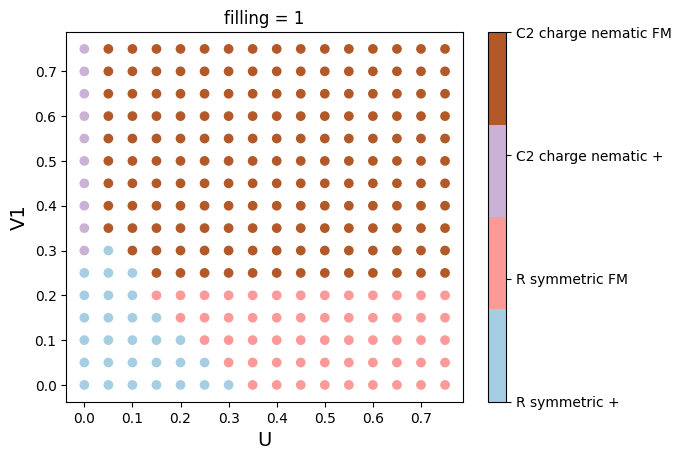

In [11]:
cmap = plt.get_cmap("Paired", len(unique_phase_index))
plt.scatter(u_mesh, v1_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('U', size = '14')
plt.ylabel('V1', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)
plt.title('filling = 1')

Text(0.5, 1.0, 'filling = 1')

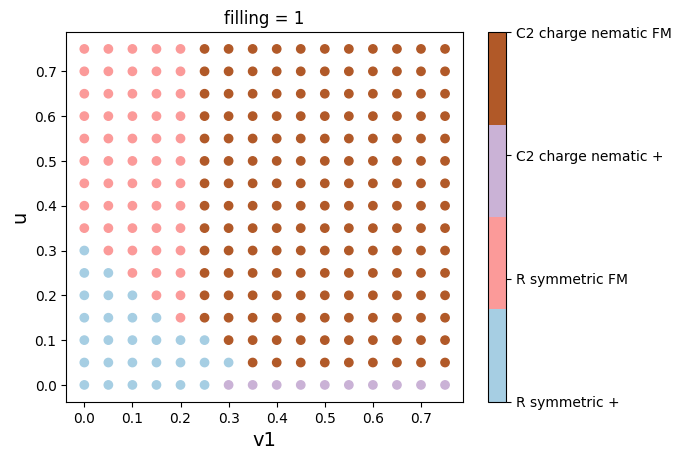

In [12]:
cmap = plt.get_cmap("Paired", len(unique_phase_index))
plt.scatter(v1_mesh, u_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('v1', size = '14')
plt.ylabel('u', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)
plt.title('filling = 1')

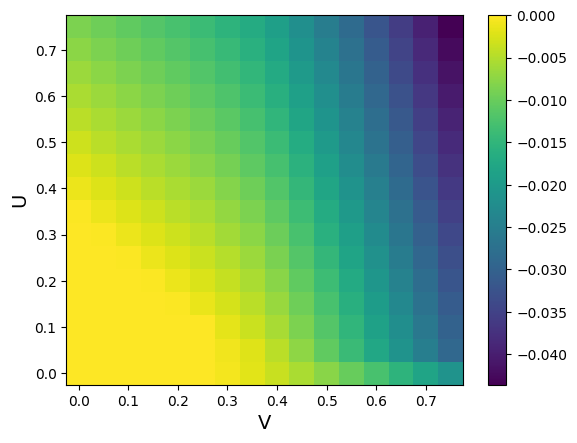

In [13]:
plt.pcolormesh(v1_mesh,u_mesh,sorted_ground_state_e[:,:,0])
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()

In [14]:
np.mean(final_iteration)

np.float64(38.51484375)

In [15]:
np.max(final_iteration)

np.int32(339)

In [16]:
np.min(final_iteration)

np.int32(2)